#### XNOR-Net (LeNet-5 Example)


```
"""
  Arg: XNOR-Net on LeNet-5
  Ref1: https://github.com/jiecaoyu/XNOR-Net-PyTorch/blob/master/MNIST/main.py
  Ref2: https://github.com/cooooorn/Pytorch-XNOR-Net
"""
```



In [1]:
# @title Binarization Operation (BinOp)
import torch.nn as nn
import numpy

class BinOp():
    def __init__(self, model):
        # count the number of Conv2d and Linear
        count_targets = 0
        for m in model.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                count_targets = count_targets + 1

        start_range = 1
        end_range = count_targets-2
        self.bin_range = numpy.linspace(start_range,
                end_range, end_range-start_range+1)\
                        .astype('int').tolist()
        self.num_of_params = len(self.bin_range)
        self.saved_params = []
        self.target_modules = []
        index = -1
        for m in model.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                index = index + 1
                if index in self.bin_range:
                    tmp = m.weight.data.clone()
                    self.saved_params.append(tmp)
                    self.target_modules.append(m.weight)
        return

    def binarization(self):
        self.meancenterConvParams()
        self.clampConvParams()
        self.save_params()
        self.binarizeConvParams()

    def meancenterConvParams(self):
        for index in range(self.num_of_params):
            s = self.target_modules[index].data.size()
            negMean = self.target_modules[index].data.mean(1, keepdim=True).\
                    mul(-1).expand_as(self.target_modules[index].data)
            self.target_modules[index].data = self.target_modules[index].data.add(negMean)

    def clampConvParams(self):
        for index in range(self.num_of_params):
            self.target_modules[index].data = \
                    self.target_modules[index].data.clamp(-1.0, 1.0)

    def save_params(self):
        for index in range(self.num_of_params):
            self.saved_params[index].copy_(self.target_modules[index].data)

    def binarizeConvParams(self):
        for index in range(self.num_of_params):
            n = self.target_modules[index].data[0].nelement()
            s = self.target_modules[index].data.size()
            if len(s) == 4:
                m = self.target_modules[index].data.norm(1, 3, keepdim=True)\
                        .sum(2, keepdim=True).sum(1, keepdim=True).div(n)
            elif len(s) == 2:
                m = self.target_modules[index].data.norm(1, 1, keepdim=True).div(n)
            self.target_modules[index].data = \
                    self.target_modules[index].data.sign().mul(m.expand(s))

    def restore(self):
        for index in range(self.num_of_params):
            self.target_modules[index].data.copy_(self.saved_params[index])

    def updateBinaryGradWeight(self):
        for index in range(self.num_of_params):
            weight = self.target_modules[index].data
            n = weight[0].nelement()
            s = weight.size()
            if len(s) == 4:
                m = weight.norm(1, 3, keepdim=True)\
                        .sum(2, keepdim=True).sum(1, keepdim=True).div(n).expand(s)
            elif len(s) == 2:
                m = weight.norm(1, 1, keepdim=True).div(n).expand(s)
            m[weight.lt(-1.0)] = 0
            m[weight.gt(1.0)] = 0
            m = m.mul(self.target_modules[index].grad.data)
            m_add = weight.sign().mul(self.target_modules[index].grad.data)
            if len(s) == 4:
                m_add = m_add.sum(3, keepdim=True)\
                        .sum(2, keepdim=True).sum(1, keepdim=True).div(n).expand(s)
            elif len(s) == 2:
                m_add = m_add.sum(1, keepdim=True).div(n).expand(s)
            m_add = m_add.mul(weight.sign())
            self.target_modules[index].grad.data = m.add(m_add).mul(1.0-1.0/s[1]).mul(n)

Conv2D with XNOR-bitcount\
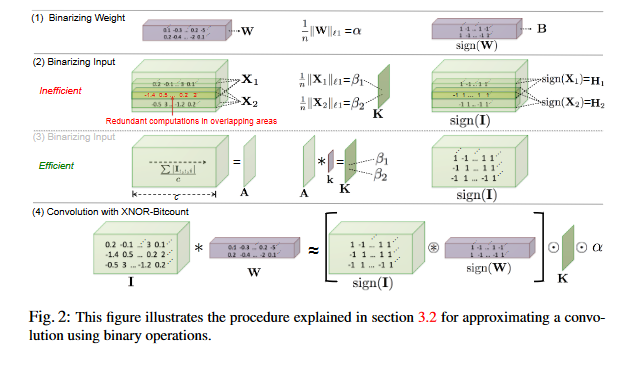

In [2]:
# @title Binarized Actication Fn., Binarized Conv2D, and Binarized LeNet-5
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinActive(torch.autograd.Function):
    '''
    Binarize the input activations and calculate the mean across channel dimension.
    '''
    @staticmethod
    def forward(ctx, input):
        # input = input.exp()
        ctx.save_for_backward(input)
        size = input.size()
        input = input.sign()
        return input

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input.ge(1)] = 0
        grad_input[input.le(-1)] = 0
        return grad_input

class BinConv2d(nn.Module): # change the name of BinConv2d
    def __init__(self, input_channels, output_channels,
            kernel_size=-1, stride=-1, padding=-1, groups=1, dropout=0,
            Linear=False, previous_conv=False, size=0):
        super(BinConv2d, self).__init__()
        self.input_channels = input_channels
        self.layer_type = 'BinConv2d'
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dropout_ratio = dropout
        self.previous_conv = previous_conv

        if dropout!=0:
            self.dropout = nn.Dropout(dropout)
        self.Linear = Linear
        if not self.Linear:
            self.bn = nn.BatchNorm2d(input_channels, eps=1e-4, momentum=0.1, affine=True)
            self.conv = nn.Conv2d(input_channels, output_channels,
                    kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
        else:
            if self.previous_conv:
                self.bn = nn.BatchNorm2d(int(input_channels/size), eps=1e-4, momentum=0.1, affine=True)
            else:
                self.bn = nn.BatchNorm1d(input_channels, eps=1e-4, momentum=0.1, affine=True)
            self.linear = nn.Linear(input_channels, output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.bn(x)
        x = BinActive.apply(x)
        if self.dropout_ratio!=0:
            x = self.dropout(x)
        if not self.Linear:
            x = self.conv(x)
        else:
            if self.previous_conv:
                # print(x.shape)
                x = x.view(x.size(0), self.input_channels)
                # x = x.view(x.size(0), -1)
            x = self.linear(x)
        x = self.relu(x)
        return x

# Remark: transform image to 28x28 for Bin_LeNet5
class Bin_LeNet5(nn.Module):
    def __init__(self):
        super(Bin_LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1)
        self.bn_conv1 = nn.BatchNorm2d(20, eps=1e-4, momentum=0.1, affine=False)
        self.relu_conv1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bin_conv2 = BinConv2d(20, 50, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bin_ip1 = BinConv2d(50*4*4, 500, Linear=True,
                previous_conv=True, size=4*4)
        self.ip2 = nn.Linear(500, 10)

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                if hasattr(m.weight, 'data'):
                    m.weight.data.zero_().add_(1.0)
        return

    def forward(self, x):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                if hasattr(m.weight, 'data'):
                    m.weight.data.clamp_(min=0.01)
        x = self.conv1(x)
        x = self.bn_conv1(x)
        x = self.relu_conv1(x)
        x = self.pool1(x)
        x = self.bin_conv2(x)
        x = self.pool2(x)

        # x = x.view(x.size(0), 50*4*4)

        x = self.bin_ip1(x)
        x = self.ip2(x)
        return x


##################################################################
# Vanilla LeNet5
# Remark: transform image to 32x32 for LeNet5
class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import sys
from torchvision import datasets, transforms
from torch.autograd import Variable

def save_state(model, acc):
    print('==> Saving model ...')
    state = {
            'acc': acc,
            'state_dict': model.state_dict(),
            }
    for key in state['state_dict'].keys():
        if 'module' in key:
            state['state_dict'][key.replace('module.', '')] = \
                    state['state_dict'].pop(key)
    if not os.path.exists('./cp'): os.makedirs('./cp');
    torch.save(state, './cp/'+args.arch+'.best.pth.tar')

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()

        # process the weights including binarization
        bin_op.binarization()

        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        # restore weights
        bin_op.restore()
        bin_op.updateBinaryGradWeight()

        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
    return

def test(evaluate=False):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0

    bin_op.binarization()
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += criterion(output, target).data.item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    bin_op.restore()

    acc = 100. * float(correct) / len(test_loader.dataset)
    if (acc > best_acc):
        best_acc = acc
        if not evaluate:
            save_state(model, best_acc)

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss * args.batch_size, correct, len(test_loader.dataset),
        100. * float(correct) / len(test_loader.dataset)))
    print('Best Accuracy: {:.2f}%\n'.format(best_acc))
    return

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 15 epochs"""
    lr = args.lr * (0.1 ** (epoch // args.lr_epochs))
    print('Learning rate:', lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

if __name__=='__main__':
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=128, metavar='N',
            help='input batch size for training (default: 128)')
    parser.add_argument('--test-batch-size', type=int, default=128, metavar='N',
            help='input batch size for testing (default: 128)')
    parser.add_argument('--epochs', type=int, default=10, metavar='N',
            help='number of epochs to train (default: 60)')
    parser.add_argument('--lr-epochs', type=int, default=15, metavar='N',
            help='number of epochs to decay the lr (default: 15)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
            help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
            help='SGD momentum (default: 0.9)')
    parser.add_argument('--weight-decay', '--wd', default=1e-5, type=float,
            metavar='W', help='weight decay (default: 1e-5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
            help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
            help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
            help='how many batches to wait before logging training status')
    parser.add_argument('--arch', action='store', default='LeNet5', choices=['Bin_LeNet5', 'LeNet5'], # edit here
            help='the MNIST network structure: LeNet_5')
    parser.add_argument('--pretrained', action='store', default=None,
            help='pretrained model')
    parser.add_argument('--evaluate', action='store_true', default=False,
            help='whether to run evaluation')
    args = parser.parse_args(args=[])
    args.cuda = not args.no_cuda and torch.cuda.is_available()

    print(args)

    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

    # generate the model
    if args.arch == 'Bin_LeNet5':
        model = Bin_LeNet5()
        image_size = 28
    elif args.arch == 'LeNet5':
        model = LeNet5()
        image_size = 32
    else:
        print('ERROR: specified arch is not suppported')
        print(f"Value of args.arch: {args.arch}")  # Print the value of args.arch
        exit()

    # load data
    kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
    train_loader = torch.utils.data.DataLoader(
            datasets.MNIST('data', train=True, download=True,
                transform=transforms.Compose([
                    transforms.Resize((image_size, image_size)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                    ])),
                batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
            datasets.MNIST('data', train=False, transform=transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
                ])),
            batch_size=args.test_batch_size, shuffle=True, **kwargs)

    if not args.pretrained:
        best_acc = 0.0
    else:
        pretrained_model = torch.load(args.pretrained)
        best_acc = pretrained_model['acc']
        model.load_state_dict(pretrained_model['state_dict'])

    if args.cuda:
        model.cuda()

    print(model)
    param_dict = dict(model.named_parameters())
    params = []

    base_lr = 0.1

    for key, value in param_dict.items():
        params += [{'params':[value], 'lr': args.lr,
            'weight_decay': args.weight_decay,
            'key':key}]

    optimizer = optim.Adam(params, lr=args.lr,
            weight_decay=args.weight_decay)

    criterion = nn.CrossEntropyLoss()

    # define the binarization operator
    bin_op = BinOp(model)

    if args.evaluate:
        test(evaluate=True)
        exit()

    for epoch in range(1, args.epochs + 1):
        adjust_learning_rate(optimizer, epoch)
        train(epoch)
        test()

Namespace(batch_size=128, test_batch_size=128, epochs=10, lr_epochs=15, lr=0.01, momentum=0.9, weight_decay=1e-05, no_cuda=False, seed=1, log_interval=100, arch='LeNet5', pretrained=None, evaluate=False, cuda=True)
LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Learning rate: 0.01


<ipython-input-1-a2d9eca078c5>:79: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:716.)
  m[weight.lt(-1.0)] = 0
<ipython-input-1-a2d9eca078c5>:79: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at ../aten/src/ATen/native/cuda/Indexing.cu:1558.)
  m[weight.lt(-1.0)] = 0
<ipython-input-1-a2d9eca078c5>:80: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:716.)
  m[weight.gt(1.0)] = 0


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308390
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.118363
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.194688
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.188501
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.089026


<ipython-input-4-120d4d4bd631>:61: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)


==> Saving model ...

Test set: Average loss: 0.0869, Accuracy: 9722/10000 (97.22%)
Best Accuracy: 97.22%

Learning rate: 0.01
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.144565
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.081268
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.253599
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.137279
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.160508
==> Saving model ...

Test set: Average loss: 0.0896, Accuracy: 9728/10000 (97.28%)
Best Accuracy: 97.28%

Learning rate: 0.01
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.019269
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.107450
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.133610
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.132709
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.089245

Test set: Average loss: 0.1071, Accuracy: 9679/10000 (96.79%)
Best Accuracy: 97.28%

Learning rate: 0.01
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.103396
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.152592
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.215351
Train

-----
# In-class exercises
1. Training เทียบกับ Non-binarized LeNet-5 (LeNet-5 แบบปกติ)
- เปรียบเทียบทรัพยากรที่ใช้ (FLOPs, parameter use, etc.)
- เปรียบเทียบผลเชิงปริมาณ (quantitative results)

-------------
# Homework
1. ปรับไปใช้ VGG-9 ทดลองปรับโมเดลโดยใช้ Binarization operation (XNOR block) เทียบกับ Non-binarized Mini-SqueezeNet โดยออกแบบให้โมเดลมีประสิทธิภาพความแม่นยำลดลง **ไม่เกิน 20 %**


- เปรียบเทียบทรัพยากรที่ใช้ก่อนและหลังทำ XNOR (FLOPs, parameter in use, etc.)
- เปรียบเทียบผลเชิงปริมาณก่อนและหลังทำ XNOR (quantitative results, e.g., accuracy, loss, precision, recall, F1-score, etc.)

```
############ Add term of "Resize image to 224x224" for VGG-9 ##############
if args.arch == 'LeNet5':
    model = LeNet5()
    image_size = 32
elif args.arch == 'Bin_LeNet5':
    model = Bin_LeNet5()
    image_size = 28
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
elif args.arch == 'VGG9':
    model = VGG9()
    image_size = 224
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
elif args.arch == 'SqueezeNet':
    model = SqueezeNet()
    image_size = 224
elif args.arch == 'Bin_SqueezeNet':
    model = Bin_SqueezeNet()
    image_size = 224
else:
    print('ERROR: specified arch is not suppported')
    print(f"Value of args.arch: {args.arch}")  # Print the value of args.arch
    exit()

######################### VGG-9 ######################
class VGG9(nn.Module):
    def __init__(self):
        super(VGG9, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 10)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x
################################################################################
######################### SqueezeNet (Non-bypass) ##############################
class FireModule(nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand1x1_channels, expand3x3_channels):
        super(FireModule, self).__init__()
        self.squeeze = nn.Sequential(
            nn.Conv2d(in_channels, squeeze_channels, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.expand1x1 = nn.Sequential(
            nn.Conv2d(squeeze_channels, expand1x1_channels, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.expand3x3 = nn.Sequential(
            nn.Conv2d(squeeze_channels, expand3x3_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        x = self.squeeze(x)
        return torch.cat([self.expand1x1(x), self.expand3x3(x)], 1)

class SqueezeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        self.feature_extractor = nn.Sequential(
            # 1st conv-maxpool block
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            # 2rd-4th Fire Module
            FireModule(64, 16, 64, 64),
            FireModule(128, 16, 64, 64),
            FireModule(128, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            # 5th-8th Fire Module
            FireModule(256, 32, 128, 128),
            FireModule(256, 48, 192, 192),
            FireModule(384, 48, 192, 192),
            FireModule(384, 64, 256, 256),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # 9th Fire Module
            FireModule(512, 64, 256, 256),
        )
        self.feature_classifier_head = nn.Sequential(
            # 10th conv-globavgpool block to flatten class features
            nn.Dropout(p=0.5),
            nn.Conv2d(512, self.num_classes, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.feature_classifier_head(x)
        x = x.view(-1, self.num_classes)
        return x
################################################################################
######################### Mini-SqueezeNet (Non-bypass) #########################
class MiniSqueezeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MiniSqueezeNet, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            # 1st conv-maxpool block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # 2rd-3th Fire Module
            FireModule(32, 8, 16, 16),
            FireModule(32, 8, 16, 16),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # 4th-5th Fire Module
            FireModule(32, 16, 32, 32),
            FireModule(64, 16, 32, 32),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # 6th Fire Module
            FireModule(64, 32, 64, 64),
        )
        self.classifier = nn.Sequential(
            # 7th conv-globavgpool block to flatten class features
            nn.Dropout(p=0.5),
            nn.Conv2d(128, num_classes, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        x = x.view(-1, self.num_classes)  # Flatten for the fully connected layer
        return x
################################################################################
```


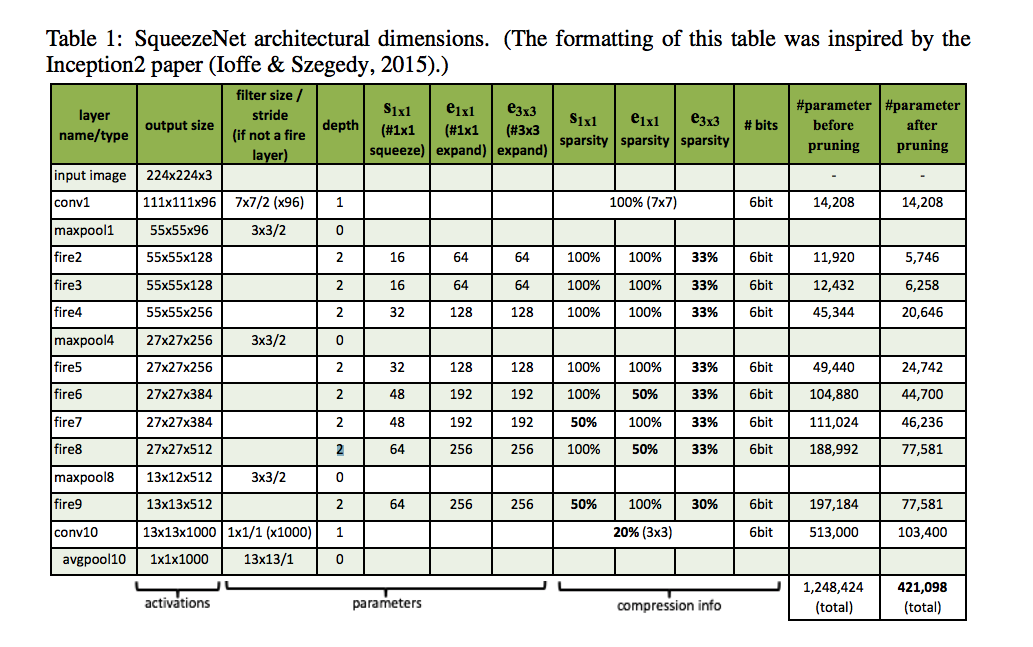